In [1]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

Cloning into 'multimodal-memes'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 281 (delta 6), reused 0 (delta 0), pack-reused 265
Receiving objects: 100% (281/281), 3.87 MiB | 6.92 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import json

sys.path.append('/content/multimodal-memes/XLNET')
sys.path.append('/content/multimodal-memes/Utils')
sys.path.append('/content/multimodal-memes/JSON Data')

from dataloader import mydataset 
from plot_curves import plot_loss, plot_acc
from unimodal_trainer import train, validation

'''
For XLNET
'''
from transformers import XLNetForSequenceClassification, AdamW, XLNetConfig
from transformers import get_linear_schedule_with_warmup


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Upload data**

In [7]:
%cd /content/multimodal-memes/JSON Data

/content/multimodal-memes/JSON Data


In [ ]:
#with open('train.jsonl', 'r') as f:
    #lines = f.readlines()

#split_idx = int(0.8*len(lines))
#train_lines = lines[:split_idx]
#val_lines = lines[split_idx:]

In [ ]:
#with open('training.json', 'w') as f:
  #for line in lines[:split_idx]:
   # f.write(line)

#with open('validation.json', 'w') as f:
  #for line in lines[split_idx:]:
    #f.write(line)


In [8]:
trainlist = 'train.jsonl'
validlist = 'test_seen.jsonl'

In [9]:
train_dataset = mydataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=16,pin_memory=True)
validation_dataset = mydataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 32, num_workers=16,pin_memory=True)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg

**Model Definition**

In [10]:
model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", #12-layer BERT model, with an uncased vocab.
    num_labels = 2, #Binary classification
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model = model.to(device)
model = nn.DataParallel(model).to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

**Hyperparameters**

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
num_Epochs = 10
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,  num_training_steps = total_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
modelname = 'XLNet_basic'
modelpath = './saved_model_checkpoints/'+modelname

In [13]:
writer = SummaryWriter(modelname)

train_loss, v_loss, v_acc = train(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, modelpath, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.6542390470666096
Validation Loss: 0.7218	Validation Accuracy: 0.5100
Epoch:  2
training loss =  0.6289185378560447
Validation Loss: 0.6920	Validation Accuracy: 0.5640
Epoch:  3
training loss =  0.5817927509770358
Validation Loss: 0.7392	Validation Accuracy: 0.5630
Epoch:  4
training loss =  0.5302328884153438
Validation Loss: 0.7837	Validation Accuracy: 0.5700
Epoch:  5
training loss =  0.47524105891921464
Validation Loss: 0.8492	Validation Accuracy: 0.5730
Epoch:  6
training loss =  0.4233513899091491
Validation Loss: 0.9803	Validation Accuracy: 0.5740
Epoch:  7
training loss =  0.3830282578903033
Validation Loss: 1.0619	Validation Accuracy: 0.5810
Epoch:  8
training loss =  0.34329592145251153
Validation Loss: 1.2613	Validation Accuracy: 0.5700
Epoch:  9
training loss =  0.32326602129111615
Validation Loss: 1.1416	Validation Accuracy: 0.5840
Epoch:  10
training loss =  0.2948343414617212
Validation Loss: 1.2597	Validation Accuracy: 0.5840


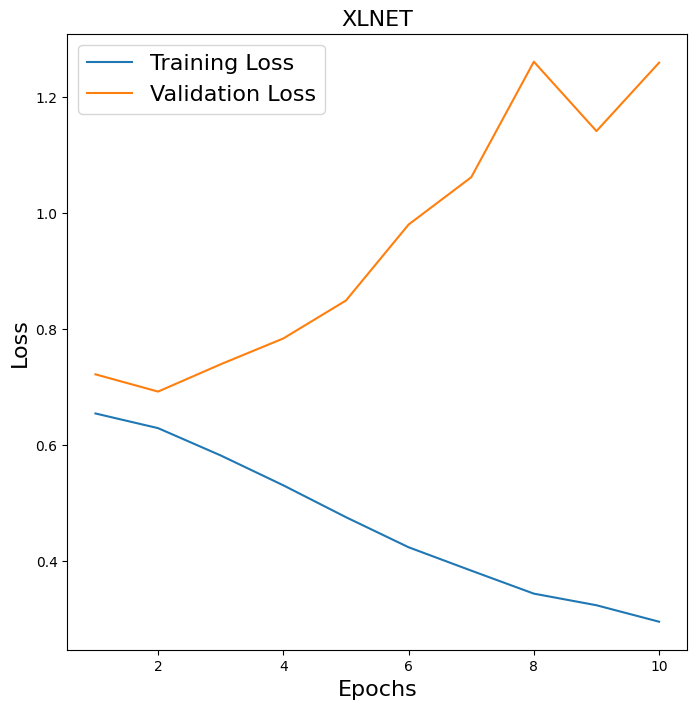

In [14]:
plot_loss((num_Epochs ), train_loss, v_loss, 'XLNET')

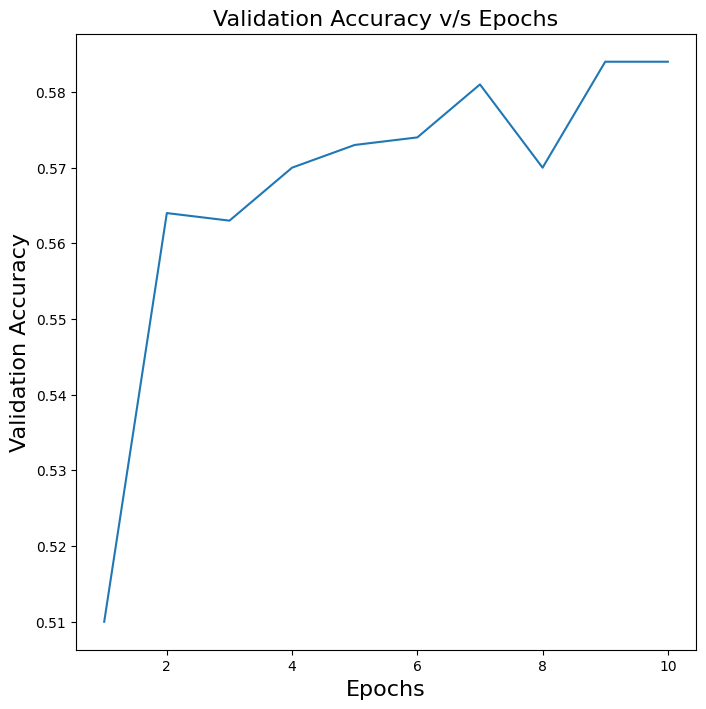

In [15]:
plot_acc((num_Epochs), v_acc)